In [39]:
import numpy as np
from gensim.models import Word2Vec
import snap
import operator
import snap
from scipy.stats import binom
import matplotlib.pyplot as plt
import scipy

# Machine learning packages

# Supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Unsupervised learning (i.e. clustering)
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# Clustering assessment metrics(for unknown ground truth)
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

In [40]:
# Find how many of the k most similar companies to a given
# node were acquired
def getNumAcquired(sim_rankings, acquired_companies_in_graph_by_id, k):
    top_rankings = sim_rankings[:k]
    result = 0
    
    for tup in top_rankings:
        company_id = int(tup[0])
        if company_id in acquired_companies_in_graph_by_id: result += 1
    
    return result

In [41]:
# For each company, find out how many of the k most similar companies
# to the given company were acquired
# IDEA: maybe companies more similar to acquired companies
# were also acquired
def getCompaniesToNumAcquired(k, node_to_sorted_L2_similarities, acquired_companies_in_graph_by_id, companies):
    result = {}

    for company_id in companies:
        sim_rankings = node_to_sorted_L2_similarities[str(company_id)]
        result[company_id] = getNumAcquired(sim_rankings, acquired_companies_in_graph_by_id, k)
                                     
    return result

In [42]:
# Get the probabilities we would expect under the null
def getNullProbs(companies_to_num_acquired, n, p):
    result = {}
    
    for key in companies_to_num_acquired:
        result[key] = binom.pmf(companies_to_num_acquired[key], n, p)
        
    return result

In [43]:
# Returns a list sorted from the node with the least l2 distance to 
# reference node to the node with the greatest l2 distance
def calculateSortedL2Similarity(reference_node, model):
    reference_embeddings = model[reference_node]
    l2_similarities = {}

    for key in model.vocab:
        if key != reference_node:
            curr_l2 = np.linalg.norm(reference_embeddings - model[key])
            l2_similarities[key] = curr_l2

    sorted_l2_similarities = sorted(l2_similarities.items(), key=operator.itemgetter(1))
    return sorted_l2_similarities

In [44]:
def createSortedSimilaritesMap(model):
    result = {}
    for key in model.vocab:
        result[key] = calculateSortedL2Similarity(key, model)
    return result

In [45]:
# Load the embeddings from memory
BFS_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/company_embeddings_p1_q100_50iters.emd")
neutral_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/company_embeddings_p1_q1_50iters.emd")
DFS_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/company_embeddings_p1_q0_01_50iters.emd")

In [46]:
'''
BFS_nodeToSortedL2Similarities = createSortedSimilaritesMap(BFS_model)
print "Completed BFS model"
neutral_nodeToSortedL2Similarities = createSortedSimilaritesMap(neutral_model)
print "Completed neutral model"
DFS_nodeToSortedL2Similarities = createSortedSimilaritesMap(DFS_model)
print "Completed DFS model"
'''
BFS_nodeToSortedL2Similarities = np.load("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q100.npy").item()
neutral_nodeToSortedL2Similarities = np.load("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q1.npy").item()
DFS_nodeToSortedL2Similarities = np.load("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q0_01.npy").item()

In [9]:
#DO NOT RUN THIS AGAIN!
'''
np.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q100", BFS_nodeToSortedL2Similarities)
np.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q1", neutral_nodeToSortedL2Similarities)
np.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q0_01", DFS_nodeToSortedL2Similarities)
'''

'\nnp.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q100", BFS_nodeToSortedL2Similarities)\nnp.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q1", neutral_nodeToSortedL2Similarities)\nnp.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q0_01", DFS_nodeToSortedL2Similarities)\n'

In [9]:
# These are all of the acquired companies we know about
acquired_companies = set(np.load("../acquired_companies.npy"))

In [12]:
# Now we find the overlap between companies in our graph and the set of acquired companies
node_id_to_value = np.load("../../graphs/investors_to_companies_directed/node_id_to_value.npy").item()
FIn = snap.TFIn("../../graphs/investors_to_companies_directed/investors_to_companies_directed_folded_reverse_order.graph")
G = snap.TUNGraph.Load(FIn)

companies_in_graph = set()
for EI in G.Edges(): 
    curr_src_id = EI.GetSrcNId()
    curr_dst_id = EI.GetDstNId()
    companies_in_graph.add(node_id_to_value[curr_src_id])
    companies_in_graph.add(node_id_to_value[curr_dst_id])
    
# These are the acquired companies in our folded graph
acquired_companies_in_graph = companies_in_graph.intersection(acquired_companies)

acquired_companies_in_graph_by_id = []
value_to_node_id = {v: k for k, v in node_id_to_value.iteritems()}
for company in acquired_companies_in_graph:
    acquired_companies_in_graph_by_id.append(value_to_node_id[company])
    
    
not_acquired_companies_in_graph = companies_in_graph.difference(acquired_companies)
not_acquired_companies_in_graph_by_id = []
for company in not_acquired_companies_in_graph:
    not_acquired_companies_in_graph_by_id.append(value_to_node_id[company])

In [13]:
# Need to look at companies that are NOT acquired too

k = 500
acquired_to_num_acquired_BFS = getCompaniesToNumAcquired(k, BFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, acquired_companies_in_graph_by_id)
acquired_to_num_acquired_neutral = getCompaniesToNumAcquired(k, neutral_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, acquired_companies_in_graph_by_id)
acquired_to_num_acquired_DFS = getCompaniesToNumAcquired(k, DFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, acquired_companies_in_graph_by_id)
# Make a plot for each of BFS, neutral, and DFS
# x axis will be node id
# y axis will be probability under null (binomial) model
p = float(len(acquired_companies_in_graph_by_id)) / len(companies_in_graph)
BFS_null_model_probabilities = getNullProbs(acquired_to_num_acquired_BFS, k, p)
neutral_null_model_probabilities = getNullProbs(acquired_to_num_acquired_neutral, k, p)
DFS_null_model_probabilities = getNullProbs(acquired_to_num_acquired_DFS, k, p)


print np.mean(acquired_to_num_acquired_BFS.values())
print np.mean(acquired_to_num_acquired_neutral.values())
print np.mean(acquired_to_num_acquired_DFS.values())



KeyError: '1259'

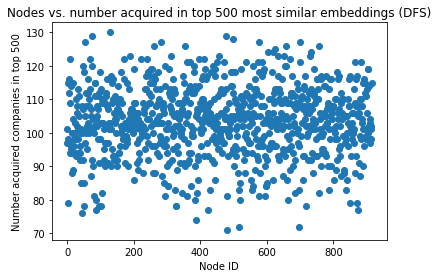

In [13]:
X = range(len(acquired_companies_in_graph_by_id))
x_vals = sorted(acquired_companies_in_graph_by_id)

y_vals = []
outliers = []
for val in x_vals:
    y_val = acquired_to_num_acquired_DFS[val]
    y_vals.append(y_val)
    if y_val >= 20: 
        outliers.append(val)

plt.xlabel("Node ID")
plt.ylabel("Number acquired companies in top " + str(k))
plt.title("Nodes vs. number acquired in top " + str(k) + " most similar embeddings (DFS)")
plt.scatter(X, y_vals)
plt.show()

In [14]:
# Need to look at companies that are NOT acquired too

k = 500
not_acquired_to_num_acquired_BFS = getCompaniesToNumAcquired(k, BFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, not_acquired_companies_in_graph_by_id)
not_acquired_to_num_acquired_neutral = getCompaniesToNumAcquired(k, neutral_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, not_acquired_companies_in_graph_by_id)
not_acquired_to_num_acquired_DFS = getCompaniesToNumAcquired(k, DFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, not_acquired_companies_in_graph_by_id)
# Make a plot for each of BFS, neutral, and DFS
# x axis will be node id
# y axis will be probability under null (binomial) model
p = float(len(acquired_companies_in_graph_by_id)) / len(companies_in_graph)
BFS_null_model_probabilities = getNullProbs(not_acquired_to_num_acquired_BFS, k, p)
neutral_null_model_probabilities = getNullProbs(not_acquired_to_num_acquired_neutral, k, p)
DFS_null_model_probabilities = getNullProbs(not_acquired_to_num_acquired_DFS, k, p)


print np.mean(not_acquired_to_num_acquired_BFS.values())
print np.mean(not_acquired_to_num_acquired_neutral.values())
print np.mean(not_acquired_to_num_acquired_DFS.values())

93.4686567164
96.0723306544
100.380482204


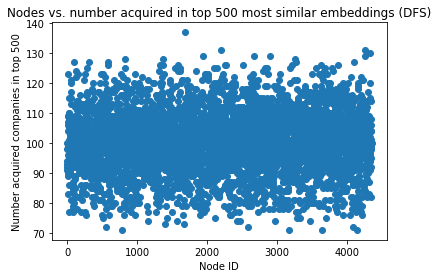

In [17]:
X = range(len(not_acquired_companies_in_graph_by_id))
x_vals = sorted(not_acquired_companies_in_graph_by_id)

outliers = []
y_vals = []
for val in x_vals:
    y_val = not_acquired_to_num_acquired_DFS[val]
    y_vals.append(y_val)
    if y_val >= 120: 
        outliers.append(val)

plt.xlabel("Node ID")
plt.ylabel("Number acquired companies in top " + str(k))
plt.title("Nodes vs. number acquired in top " + str(k) + " most similar embeddings (DFS)")
plt.scatter(X, y_vals)
plt.show()

In [37]:
# Returns train and test sets with fraction train_frac 
# of the total number of datapoints in the train set
def getData(model, train_frac):
    
    
    
    # Use node2vec and logistic regression to make predictions
    node_2_vec_embedding_dimension = 128

    train_companies = set([])
    for company in companies_in_graph: 
        if np.random.rand() < train_frac: train_companies.add(company)
              
    test_companies = companies_in_graph.difference(train_companies)

    train_X = np.zeros((len(train_companies), node_2_vec_embedding_dimension))
    train_Y = np.zeros((len(train_companies),))

    train_companies = list(train_companies)
    for i in range(len(train_companies)):
        company_id = value_to_node_id[train_companies[i]]
        company_embedding = model[str(company_id)]
        train_X[i] = company_embedding
        if company_id in acquired_companies_in_graph_by_id:
            train_Y[i] = 1
        else:
            train_Y[i] = 0

    test_X = np.zeros((len(test_companies), node_2_vec_embedding_dimension))
    test_Y = np.zeros((len(test_companies),))

    test_companies = list(test_companies)
    for i in range(len(test_companies)):
        company_id = value_to_node_id[test_companies[i]]
        company_embedding = model[str(company_id)]
        test_X[i] = company_embedding
        if company_id in acquired_companies_in_graph_by_id:
            test_Y[i] = 1
        else:
            test_Y[i] = 0 
            
    return train_X, train_Y, test_X, test_Y

SUPERVISED LEARNING:

We'll now use the node2vec embeddings to make predictions

In [29]:
def assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model):
    train_predictions = fitted_model.predict(train_X)
    test_predictions = fitted_model.predict(test_X)
    print "Train confusion matrix (rows correspond to true labels)"
    print confusion_matrix(train_Y, train_predictions, labels=[0, 1])
    print "Test confusion matrix (rows correspond to true labels)"
    print confusion_matrix(test_Y, test_predictions, labels=[0, 1])

    print "Train score"
    print fitted_model.score(train_X, train_Y)
    print "Test score"
    print fitted_model.score(test_X, test_Y)
    print ""

In [30]:
def logistic_regression(train_X, train_Y, test_X, test_Y, class_weight):
    # Weight the less common class more heavily
    # For the confustion matrix, rows correspond to true labels and columns to predicted labels
    fitted_model = LogisticRegression(class_weight={0:1, 1:2}).fit(train_X, train_Y)
    print "Successfully fitted logistic regression classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [31]:
# Looks like logistic regression mostly predicts not acquired the vast majority of the time as expected
# Let's see if a simple neural net can do any better
def mlp_classifier(train_X, train_Y, test_X, test_Y):
    fitted_model = MLPClassifier().fit(train_X, train_Y)
    print "Successfully fitted MLP classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [32]:
# No surprise that the neural net overfit
# Let's now try using KNN
def knn_classifier(train_X, train_Y, test_X, test_Y, k):
    fitted_model = KNeighborsClassifier(n_neighbors=10).fit(train_X, train_Y)
    print "Successfully fitted KNN classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [33]:
# Now we'll try using a decision tree
def decision_tree_classifier(train_X, train_Y, test_X, test_Y):
    fitted_model = DecisionTreeClassifier().fit(train_X, train_Y)
    print "Successfully fitted decision tree classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [34]:
# Finally, we'll give the random forest a go
# This model turns a bunch of weaker decision
# models into a more powerful ensemble model
def random_forest_classifier(train_X, train_Y, test_X, test_Y):
    fitted_model = RandomForestClassifier().fit(train_X, train_Y)
    print "Successfully fitted random forest classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [38]:
train_X, train_Y, test_X, test_Y = getData(BFS_model, 0.8)

logistic_regression(train_X, train_Y, test_X, test_Y, {0:1, 1:2})
mlp_classifier(train_X, train_Y, test_X, test_Y)
knn_classifier(train_X, train_Y, test_X, test_Y, 10)
decision_tree_classifier(train_X, train_Y, test_X, test_Y)
random_forest_classifier(train_X, train_Y, test_X, test_Y)

AttributeError: 'Word2Vec' object has no attribute 'keys'

UNSUPERVISED LEARNING:

We'll now use the node2vec embeddings to identify clusters within the graph

In [26]:
def assess_clustering_model(fitted_model, train_X, test_X=None):
    train_is_whole_dataset = True if test_X == None else False
    
    train_cluster_assignments = fitted_model.predict(train_X)
    test_cluster_assignments = None if train_is_whole_dataset else fitted_model.predict(test_X)
    
    # Compute the mean silhoutte score across all samples
    # For silhouette scores, the best value is 1 and the worst value is -1
    # Values near 0 indicate overlapping clusters
    train_silhouette_score = silhouette_score(train_X, train_cluster_assignments)
    test_silhouette_score = None if train_is_whole_dataset else silhouette_score(test_X, test_cluster_assignments)
    print "Train silhouette score:" 
    print train_silhouette_score
    print "Test silhouette score:"
    print test_silhouette_score

    # Compute the mean Calinski-Harabasz index for all samples
    # For Calinski-Harabasz, the higher the better
    train_ch_score = calinski_harabaz_score(train_X, train_cluster_assignments)
    test_ch_score = None if train_is_whole_dataset else calinski_harabaz_score(test_X, test_cluster_assignments)
    print "Train Calinski-Harabasz score:"
    print train_ch_score
    print "Test Calinski-Harabasz score:"
    print test_ch_score
    print ""
    return train_silhouette_score

In [27]:
# Let's assume we don't know anything about the companies
# We'll use k-means to cluster their node2vec embeddings
def k_means(train_X, test_X, k):
    fitted_model = KMeans(n_clusters=k).fit(train_X)
    print "Successfully fitted K Means"
    assess_clustering_model(fitted_model, train_X, test_X)

In [30]:
# Now we try agglomerative clustering
# Note that agglomerative clustering has no concept of training
def agglomerative_clustering(train_X, test_X, k):
    data = np.concatenate((train_X, test_X))
    fitted_model = AgglomerativeClustering(n_clusters=k).fit_predict(data)
    print "Successfully fitted agglomerative clustering"
    assess_clustering_model(fitted_model, data)

In [31]:
# DFS appears to be the best for clustering
train_X, train_Y, test_X, test_Y = getData(DFS_model, 0.8)

k_means(train_X, test_X, 2)
agglomerative_clustering(train_X, test_X, 2)

Successfully fitted K Means


/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


Train silhouette score:
0.530177544643
Test silhouette score:
0.519283608347
Train Calinski-Harabasz score:
597.638918349
Test Calinski-Harabasz score:
155.49198662

Successfully fitted agglomerative clustering


AttributeError: 'numpy.ndarray' object has no attribute 'predict'